In [38]:
import torch
import os

import numpy as np
import torchvision
from torch import nn
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torch.utils.data import DataLoader
from bokeh.plotting import figure
from bokeh.io import show
from bokeh.models import LinearAxis, Range1d


In [39]:
class ImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.files = os.listdir(os.path.join(self.data_dir, 'fake'))
        self.files.extend(os.listdir(os.path.join(self.data_dir, 'real')))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        label = 0 if 'real' in self.files[idx] else 1  # 0=REAL, 1=FAKE
        if label == 1:
            image = read_image(os.path.join(self.data_dir, 'fake', self.files[idx]))
        else:
            image = read_image(os.path.join(self.data_dir, 'real', self.files[idx]))

        if self.transform:
            image = self.transform(image)
        return image, label


Feature batch shape: torch.Size([32, 3, 600, 600])
Labels batch shape: 32


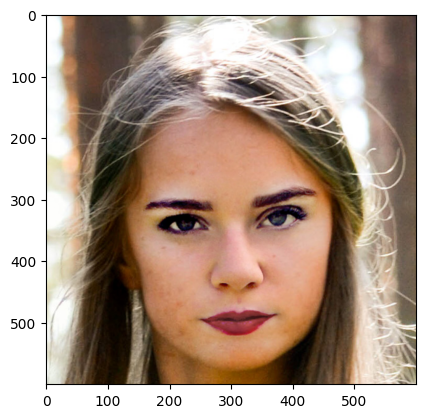

Label: 1


In [40]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToPILImage(), torchvision.transforms.ToTensor()])
training_data = ImageDataset('..\data\\training', transform=transform)
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {len(train_labels)}")
img = train_features[0].squeeze().permute(1, 2, 0)
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [44]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(3, 32, kernel_size=5, stride=3, padding=2),
                                    nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=5, stride=3, padding=2),
                                    nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout(0.2)
        self.fc1 = nn.Linear(18496, 1000)
        self.fc2 = nn.Linear(1000, 1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = ConvNet()
model = nn.DataParallel(model)
model.to(device)
learning_rate = 0.0001
num_epochs = 10
total_step = len(train_dataloader)
criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_list = []
acc_list = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dataloader):
        if device.type == 'cuda':
            images = images.cuda()
            labels = labels.cuda()
        # feed forward 
        outputs = model(images)
        labels = labels.unsqueeze(1).float()
        loss = criterion(outputs, labels)

        # back propagation 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accuracy 
        total = labels.size(0)
        predicted = (outputs.data > 0.5).float()
        correct = (predicted == labels).sum().item()
        
        if i % 16 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                      (correct / total) * 100))
            loss_list.append(loss.item())
            acc_list.append(correct / total)


cuda
Epoch [1/10], Step [1/64], Loss: 0.6917, Accuracy: 50.00%
Epoch [1/10], Step [2/64], Loss: 0.7428, Accuracy: 62.50%
Epoch [1/10], Step [3/64], Loss: 1.0234, Accuracy: 25.00%
Epoch [1/10], Step [4/64], Loss: 0.7042, Accuracy: 50.00%
Epoch [1/10], Step [5/64], Loss: 0.7205, Accuracy: 53.12%
Epoch [1/10], Step [6/64], Loss: 0.5809, Accuracy: 68.75%
Epoch [1/10], Step [7/64], Loss: 0.6806, Accuracy: 59.38%
Epoch [1/10], Step [8/64], Loss: 0.9745, Accuracy: 28.12%
Epoch [1/10], Step [9/64], Loss: 0.7622, Accuracy: 46.88%
Epoch [1/10], Step [10/64], Loss: 0.7551, Accuracy: 40.62%
Epoch [1/10], Step [11/64], Loss: 0.7285, Accuracy: 65.62%
Epoch [1/10], Step [12/64], Loss: 0.7216, Accuracy: 34.38%
Epoch [1/10], Step [13/64], Loss: 0.6794, Accuracy: 59.38%
Epoch [1/10], Step [14/64], Loss: 0.6227, Accuracy: 68.75%
Epoch [1/10], Step [15/64], Loss: 0.6993, Accuracy: 56.25%
Epoch [1/10], Step [16/64], Loss: 0.7679, Accuracy: 50.00%
Epoch [1/10], Step [17/64], Loss: 0.7742, Accuracy: 46.88%
E

In [58]:
p = figure(y_axis_label='Loss', width=850, y_range=(0, 1), title='PyTorch ConvNet results')
p.extra_y_ranges = {'Accuracy': Range1d(start=0, end=100)}
p.add_layout(LinearAxis(y_range_name='Accuracy', axis_label='Accuracy (%)'), 'right')
p.line(np.arange(len(loss_list)), loss_list)
p.line(np.arange(len(loss_list)), np.array(acc_list) * 100, y_range_name='Accuracy', color='red')
show(p)

In [59]:
torch.save(model.state_dict(), os.path.join('../models', f'cnn_{loss_list[-1]}_acc_{acc_list[-1]}.ckpt'))